In [1]:
#!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
#!unzip -qq Flickr8k_Dataset.zip

In [42]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip -q glove.6B.zip

--2023-07-12 12:33:16--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-07-12 12:33:16--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-07-12 12:33:17--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [2]:
#!pip install keras_nlp

In [3]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import keras_nlp
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers import TextVectorization

Using TensorFlow backend


In [4]:
# Path to the images
IMAGES_PATH = "Flicker8k_Dataset"

# Desired image dimensions
IMAGE_SIZE = (299, 299)

# Vocabulary size
VOCAB_SIZE = 10000

# Fixed length allowed for any sequence
SEQ_LENGTH = 25

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 256

# Per-layer units in the feed-forward network
FF_DIM = 128

# Other training parameters
BATCH_SIZE = 64
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE

##Preparing the dataset

In [5]:
def load_captions_data(filename):
    """Loads captions (text) data and maps them to corresponding images.

    Args:
        filename: Path to the text file containing caption data.

    Returns:
        caption_mapping: Dictionary mapping image names and the corresponding captions
        text_data: List containing all the available captions
    """
    df = pd.read_csv(filename, sep=',')
    caption_mapping = {}
    text_data = []
    images_to_skip = set()

    for index, row in df.iterrows():
      # each image is repeated 5 times
      img_name, caption = row
      img_name = os.path.join(IMAGES_PATH, img_name.strip())

      tokens = caption.strip().split()

      #Remove image with too short or too long caption
      if len(tokens)<5 or len(tokens)>SEQ_LENGTH:
        images_to_skip.add(img_name)
        continue

      if img_name.endswith("jpg") and img_name not in images_to_skip:
        # adding a start and an end token to each caption
        caption = "<start> " + caption.strip() + " <end>"
        text_data.append(caption)

        if img_name in caption_mapping:
          caption_mapping[img_name].append(caption)
        else:
          caption_mapping[img_name] = [caption]

    for img_name in images_to_skip:
      if img_name in caption_mapping:
        del caption_mapping[img_name]

    return caption_mapping, text_data

captions_mapping, text_data = load_captions_data("captions.txt")

In [6]:
def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    all_img = list(caption_data.keys())

    if shuffle:
      np.random.shuffle(all_img)

    train_size = int(len(caption_data) * train_size)

    train_data = {
        img_name: captions_mapping[img_name] for img_name in all_img[:train_size]
        }

    val_data = {
        img_name: captions_mapping[img_name] for img_name in all_img[train_size:]
        }

    return train_data, val_data


train_data, valid_data = train_val_split(captions_mapping)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))

Number of training samples:  6114
Number of validation samples:  1529


##Vectorizing the text data

In [48]:
def custom_standardization(input_string):
  """
  Remove all strip chars from input_string
  """
  lowercase = tf.strings.lower(input_string)
  return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


def get_embedding_matrix(vectorizer):
  vocab = vectorizer.get_vocabulary()
  num_tokens = len(vocab)
  word_index = dict(zip(vocab, range(len(vocab))))
  hits = 0
  misses = 0

  embeddings_index = {}
  with open("/content/glove.6B.300d.txt") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

  embedding_matrix = np.zeros((num_tokens, 300))
  for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1

  print(f"hits: {hits}, misses: {misses}")
  return embedding_matrix

strip_chars = "!\"#$%&'()*+,-./:;=?@[\]^_`{|}~"

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
vectorization.adapt(text_data)

embedding_matrix = get_embedding_matrix(vectorization)

hits: 7694, misses: 978


##Building a tf.data.Dataset pipeline for training

In [8]:
def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def process_input(img_path, captions):
    return decode_and_resize(img_path), vectorization(captions)

def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return dataset


train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))
valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))

##Data visualization

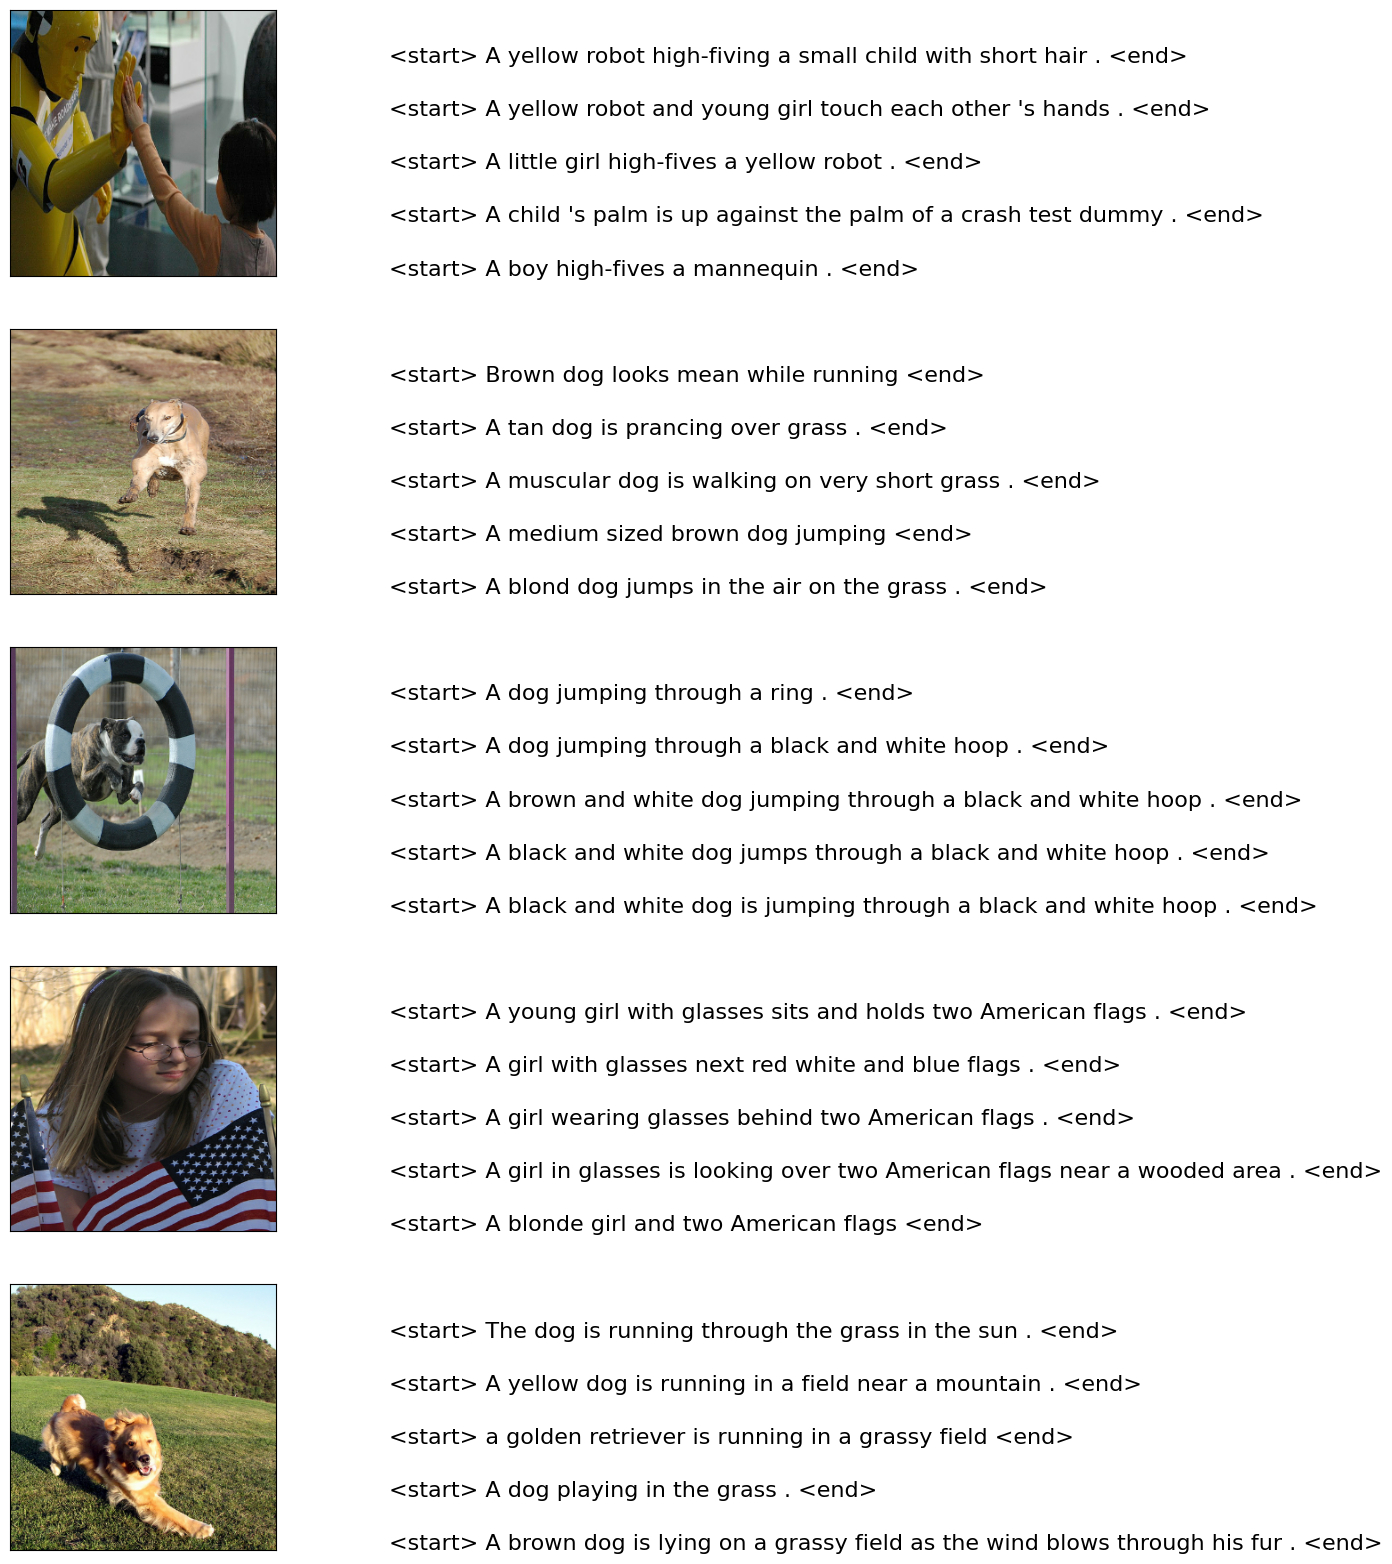

In [9]:
npic=5
count = 1
fig = plt.figure(figsize=(10,20))
all_images = list(captions_mapping.keys())

for i in range(npic):
    sample_img = np.random.choice(all_images)
    captions = captions_mapping[sample_img]

    sample_img = decode_and_resize(sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)

    ax = fig.add_subplot(npic, 2, count, xticks=[], yticks=[])
    ax.imshow(img)
    count += 1

    ax = fig.add_subplot(npic, 2 , count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0, len(captions))
    for i, caption in enumerate(captions):
        ax.text(0, i, caption, fontsize=16)
    count += 1

##Building the model

In [31]:
def get_cnn_model():
  base_model = efficientnet.EfficientNetB0(
      input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet",
  )
  # We freeze our feature extractor
  base_model.trainable = False
  base_model_out = base_model.output
  base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
  cnn_model = keras.models.Model(base_model.input, base_model_out)
  return cnn_model

In [27]:
class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads=2, attention_drop=0.0, dense_drop=0.0, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_drop = attention_drop
        self.dense_drop = dense_drop

        self.attantion_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=attention_drop
        )
        self.norm_1 = layers.LayerNormalization()
        self.norm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")
        self.dense_2 = layers.Dense(dense_dim, activation="relu")
        self.dense_3 = layers.Dense(embed_dim, activation="relu")
        self.drop_1 = layers.Dropout(dense_drop)

    def call(self, inputs, training, mask=None):
        inputs = self.dense_1(inputs)

        residuals = inputs
        inputs = self.attantion_1(
            query=inputs,
            value=inputs,
            key=inputs,
            training=training,
            attention_mask=None
        )
        inputs = self.norm_1(inputs + residuals, training=training)

        residuals = inputs
        inputs = self.dense_2(inputs, training=training)
        inputs = self.drop_1(inputs, training=training)
        inputs = self.dense_3(inputs, training=training)
        inputs = self.norm_2(inputs + residuals, training=training)

        return inputs

    def get_config(self):
        return {"embed_dim": self.embed_dim,
                "dense_dim": self.dense_dim,
                "num_heads": self.num_heads,
                "attention_drop": self.attention_drop,
                "dense_drop": self.dense,}

    def from_config(self, config):
        return TransformerEncoderBlock(**config)

In [61]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, embed_dim, embedding_matrix, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

        self.token_embeddings = layers.Embedding(
            input_dim = embedding_matrix.shape[0],
            output_dim = embedding_matrix.shape[1],
            embeddings_initializer=keras.initializers.Constant(embedding_matrix),
            trainable=False,
        )

        self.drop = layers.Dropout(0.4)
        self.dense = layers.Dense(embed_dim)

    def call(self, inputs, training=True):
        embedded_tokens = self.token_embeddings(inputs)
        mbedded_tokens = self.drop(embedded_tokens)
        embedded_tokens = self.dense(embedded_tokens)
        embedded_positions = keras_nlp.layers.SinePositionEncoding()(embedded_tokens)
        return embedded_tokens + embedded_positions

    def get_config(self):
        return {"embed_dim": self.embed_dim}

    def from_config(self, config):
        return PositionalEmbedding(**config)

In [62]:
class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM, embedding_matrix=embedding_matrix
        )
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)

    def call(self, inputs, encoder_outputs, training, mask=None):
      if mask is not None:
          mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)

      inputs = self.embedding(inputs)

      residuals = self.attention_1(
          value=inputs,
          key=inputs,
          query=inputs,
          training=training,
          use_causal_mask=True
      )

      inputs = self.layernorm_1(inputs + residuals)

      residuals = self.attention_2(
          value=encoder_outputs,
          key=encoder_outputs,
          query=inputs,
          training=training,
          attention_mask=mask
      )

      inputs = self.layernorm_2(inputs + residuals, training=training)

      residuals = inputs
      inputs = self.ffn_layer_1(inputs, training=training)
      inputs = self.dropout_1(inputs, training=training)
      inputs = self.ffn_layer_2(inputs, training=training)

      inputs = self.layernorm_3(inputs + residuals, training=training)
      inputs = self.dropout_2(inputs, training=training)
      preds = self.out(inputs)

      return preds


In [63]:
class ImageCaptioningModel(keras.Model):
    def __init__(
        self, cnn_model, encoder, decoder, num_captions_per_image=5, image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        img_embed = self.cnn_model(batch_img)

        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                batch_loss += loss
                batch_acc += acc

            train_vars = self.encoder.trainable_variables + \
                         self.decoder.trainable_variables

            grads = tape.gradient(loss, train_vars)
            self.optimizer.apply_gradients(zip(grads, train_vars))

        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        img_embed = self.cnn_model(batch_img)

        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=True
            )

            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.acc_tracker]

In [64]:
image_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomContrast(0.3),
    ])

cnn_model = get_cnn_model(embed_dim=EMBED_DIM)
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)

##Model Training

In [65]:
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False, reduction="none"
)

# Add callback
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# Compile the model
caption_model.compile(optimizer=keras.optimizers.Adam(1e-4), loss=cross_entropy)

# Fit the model
caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
)

Epoch 1/30
96/96 [==============================] - 77s 550ms/step - loss: 27.9691 - acc: 0.1502 - val_loss: 22.8198 - val_acc: 0.2646
Epoch 2/30
96/96 [==============================] - 47s 487ms/step - loss: 21.3650 - acc: 0.2785 - val_loss: 20.5012 - val_acc: 0.3038
Epoch 3/30
96/96 [==============================] - 49s 513ms/step - loss: 19.6714 - acc: 0.3112 - val_loss: 19.3816 - val_acc: 0.3241
Epoch 4/30
96/96 [==============================] - 50s 512ms/step - loss: 18.6479 - acc: 0.3283 - val_loss: 18.7181 - val_acc: 0.3352
Epoch 5/30
96/96 [==============================] - 48s 499ms/step - loss: 17.9420 - acc: 0.3407 - val_loss: 18.2186 - val_acc: 0.3408
Epoch 6/30
96/96 [==============================] - 48s 498ms/step - loss: 17.3937 - acc: 0.3498 - val_loss: 17.8614 - val_acc: 0.3478
Epoch 7/30
96/96 [==============================] - 50s 522ms/step - loss: 16.9553 - acc: 0.3565 - val_loss: 17.6389 - val_acc: 0.3555
Epoch 8/30
96/96 [==============================] - 49s

## Pedicted caption visualization

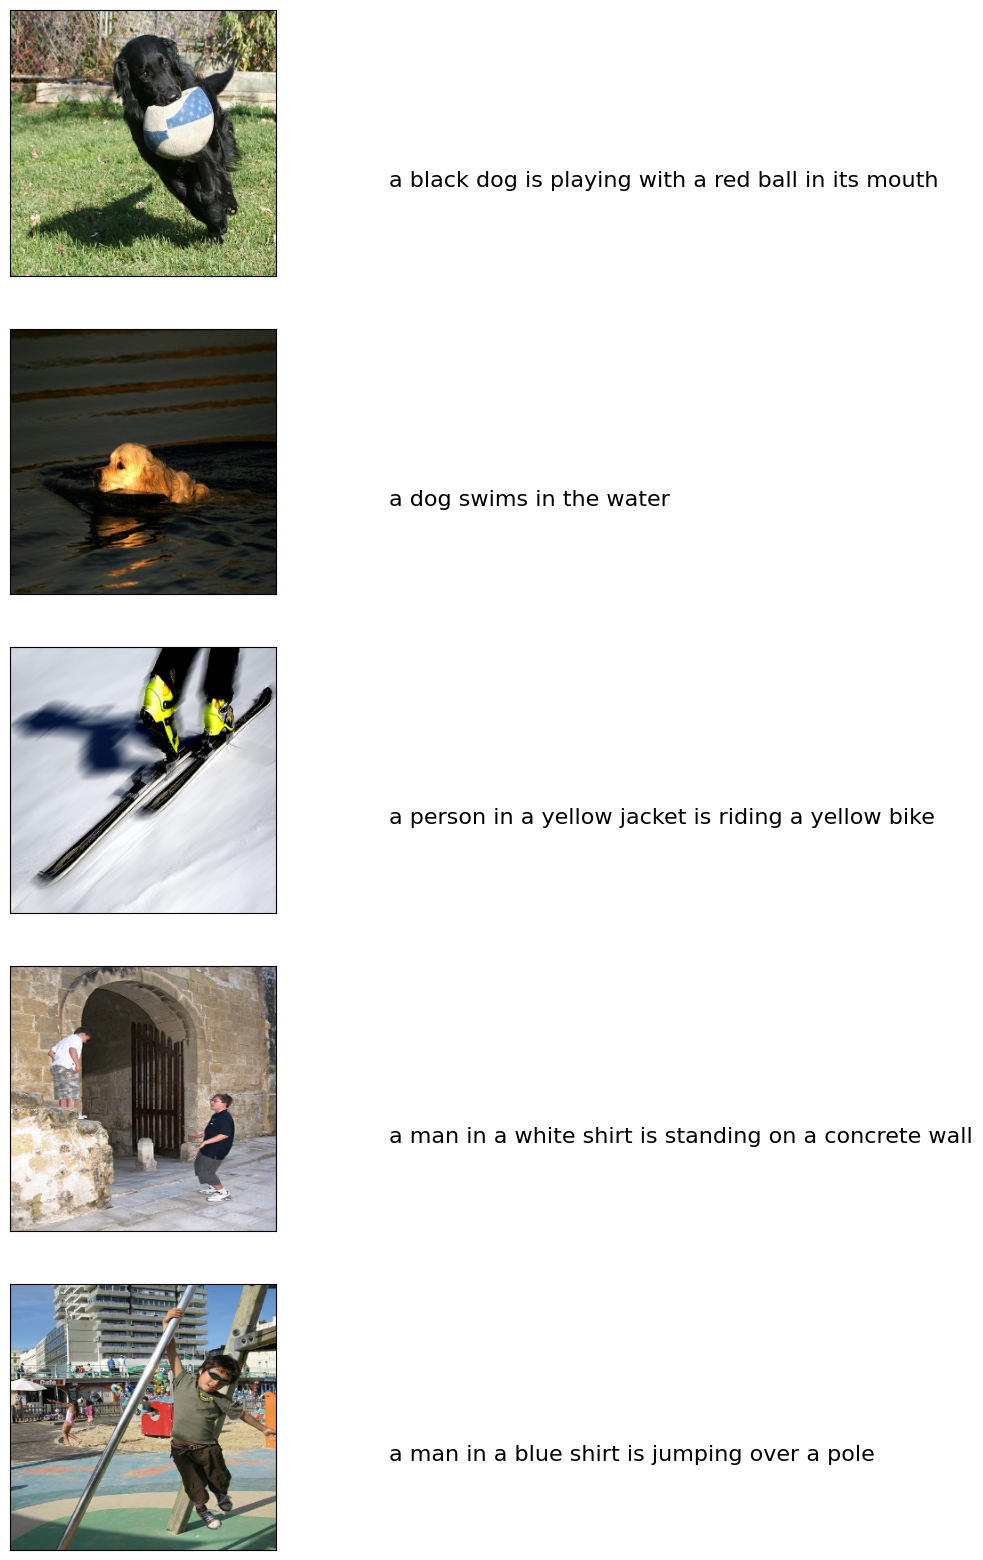

In [58]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())

fig = plt.figure(figsize=(10,20))
count=1
npic = 5

for i in range(npic):
    # Select a random image from the validation dataset
    sample_img = np.random.choice(valid_images)

    # Read the image from the disk
    sample_img = decode_and_resize(sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)

    ax = fig.add_subplot(npic, 2, count, xticks=[], yticks=[])
    ax.imshow(img)
    count += 1

    ax = fig.add_subplot(npic, 2 , count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")  # remove special tokens
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    ax.set_ylim(0, 3)
    ax.text(0, 1, decoded_caption, fontsize=16)
    count += 1

In [66]:
caption_model.save_weights('model_weights.h5')